In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import ast

# Step 2
Extract keypoints

In [2]:
# Extract SIFT features from an image
def extract_sift_features(img):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [3]:
# Get descriptors from all images in the pathrr
def get_descriptors(path):
    descriptors_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            descriptors = extract_sift_features(img)
            if descriptors is not None:
                descriptors_list.extend(descriptors)
    return descriptors_list

In [6]:
path = './webapp/data/coco128_extend1024/images'
descriptors = get_descriptors(path)

In [7]:
len(descriptors)

919379

In [8]:
import random

descriptors = random.sample(descriptors, 200000)
len(descriptors)

200000

# Step 3
Fit k-Means(n_clusters=512)

In [9]:
# Fit model 
K_Means_model = KMeans(n_clusters=1024, random_state=0).fit(descriptors)

c:\Users\Shireee\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
# Save model
with open('./webapp/models/kmeans_model1024.pkl', 'wb') as f:
    pickle.dump(K_Means_model, f)

In [5]:
# Load model 
with open('./webapp/models/kmeans_model1024.pkl', 'rb') as f:
    K_Means_model = pickle.load(f)

# Step 4
ImageToVector

In [11]:
# Image to vector transformation
def image_to_vector(image, model):
    descriptors = extract_sift_features(image)
    if descriptors is not None:
        descriptors = descriptors.astype('float64')  # convert 
        predict_kmeans = model.predict(descriptors)
        histogram = np.bincount(predict_kmeans, minlength=model.n_clusters)
        return normalize(histogram.reshape(1, -1))
    else:
        return None

# Step 5
Index all images 

In [12]:
# Create pd.DataFrame for all images in path
def create_database(path, model):
    data = []
    for index, filename in enumerate(os.listdir(path)):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            vector = image_to_vector(img, model)
            if vector is not None:
                data.append({'index': index, 'path': os.path.join(path, filename), 'vector': vector.tolist()[0]})
    df = pd.DataFrame(data)
    return df

In [13]:
# Create the database
df = create_database('./webapp/data/voc2012/Images', K_Means_model)

# Save the database to a csv file
df.to_csv('database1024.csv', index=False)

# Step 6
Image search realization

In [14]:
# Import image db
df = pd.read_csv('./webapp/data/database1024.csv')

# Convert strings to lists
vectors = np.array(df['vector'].apply(ast.literal_eval).tolist())

In [16]:
# Fit NearestNeighbors model
NN_model  = NearestNeighbors(metric='cosine').fit(vectors)

In [18]:
# Save model
with open('./webapp/models/NN_model1024.pkl', 'wb') as f:
    pickle.dump(NN_model, f)

In [10]:
# Load model 
with open('./webapp/models/NN_model1024.pkl', 'rb') as f:
    NN_model = pickle.load(f)

In [19]:
def search_image(image, K_Means_model, NN_model, k):
    # Convert image to vector
    vector = image_to_vector(image, K_Means_model)
    
    # Find the k-nearest vectors
    distances, indices = NN_model.kneighbors(vector, n_neighbors=k)
    
    # Get the paths of the k-nearest images
    paths = df.loc[indices[0], 'path']
    
    return paths.tolist()

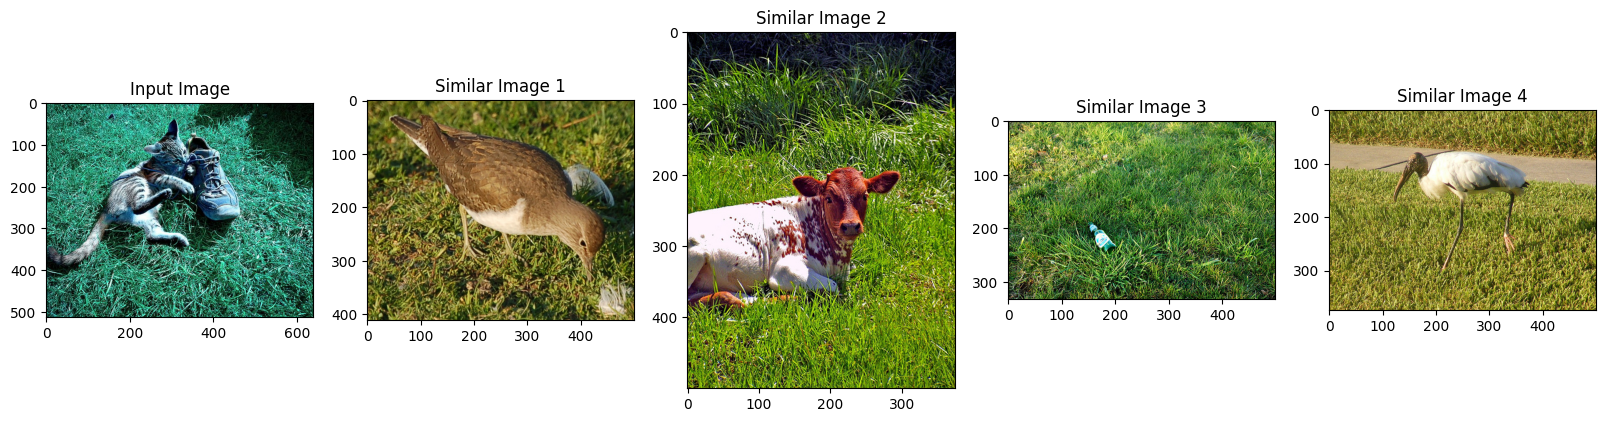

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('./webapp/data/coco128_extend1024/images/000000000575.jpg')
k  = 4
# Display the input image
plt.figure(figsize=(20, 10))
plt.subplot(1, k+1, 1)
plt.imshow(image)
plt.title('Input Image')

# Search for similar images
similar_images = search_image(image, K_Means_model, NN_model, k)

# Display the similar images
for i, path in enumerate(similar_images, 2):
    img = mpimg.imread(path)
    plt.subplot(1, k+1, i)
    plt.imshow(img)
    plt.title(f'Similar Image {i-1}')

plt.show()